In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Binary Classification of Insurance with Adaboost (Kaggle Competition)


## 1. Adaboost Implementation 

**1. Implement AdaBoost Algorithm:**
   - I managed to properly implement the AdaBoost algorithm and have found some issues and challenges with adjusting the code to work with proper dataframe. There were a lot of small mismatches of data types, indeces, variables we pass on to functions etc. Also, working with a much bigger dataset forced me to look for methods to cut the data without losing its variability, which led me to using a stratified split.


**2. Explore Margins and Analyse Results:**
   - I examined the margins and found that the highest margins that model has are related to correct predictions, whereas all the incorrect ones have the lower half of margin values. This demonstrates that the model is pretty confident about its predictions and very unlikely would hallucinate.I also visualized these margins with scatter plots and histograms, showing that higher confidence mostly goes with correct predictions.


**3. Adjust Weak Classifier Type:**
   - I conducted an experiment with different weak classifier types within the AdaBoost ensemble where I tried using Gaussian Naive Bayes (NB), k-Nearest Neighbors (kNN), and Logistic Regression (LR).
   - As a result of doing the above, I found that all three models showed similar overall accuracy, which suggests that the choice of weak classifier doesn't have a significant impact on the AdaBoost effieciency.


**4. Adjust Classification Threshold:**
   - I forced AdaBoost focus to more on challenging examples by adjusting the weights of misclassified samples. 
   - I analysed the effect of emphasizing these examples on the accuracy and generalization of the model and found that focusing more on misclassified samples creates an imbalance on a recall-precision trade-off scales.
   - I explored the impact of adjusting the classification threshold for decision-making and noticed that the higher rate and threshlods are, the higher recall, but precision and accuracy suffers. We can use it when capturing positive predictions is more important than mistaking them with negative ones. When we use an average rate and lower thresholds it looks more balanced: accuracy is good, but the recall is low. Overall, we observe the classical recall-precision trade-off, which allows us to tune the model depending on our goals and priorities.
   
**5. Implement an ensemble pruning/optimisation procedure that is executed after the model training :**
   - I managed to implement pruning in the AdaBoost ensemble by emoving weak classifiers that did not contribute significantly to the overall accuracy. 
   - My pruning strategy led to flatening the accuracy to the same rate of 0.86, no matter the the pruning proportion, because after some point model classified everything the same as -1. I think this happened because chasing the improvement in accuracy, the model learned that classifying the whole dataset as the same label is more efficient than actually trying to classify.
   
## 2. Applying obtained AdaBoost Algorithm


## 3. Kaggle Competition Using a Range of Algorithms 

1. I used the following algorithms for the Kaggle competition: XGB, CatBoost, LGBM
2. I used Hyperparameter Tuning where Necessary where I focused on tuning the following algorithms and the following hyperparameters: eta, max_depth, and subsample


## 1. Adaboost Implementation 

### 1.1 Implement AdaBoost Algorithm: 


In [5]:
from pylab import rcParams

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, early_stopping


In [6]:
def calculate_decision_stump(x, w, l):
    x = np.array(x)
    
    if x.dtype == bool:
        x = x.astype(int)
        
    min_error = np.inf
    best_thresh = 0
    best_dir = 0
    interval = np.abs(x.max() - x.min()) / 100.0
    threshold = np.arange(x.min() - interval * 2.0, x.max() + interval * 2.0, interval)
    temp_err = 0.0
    
    for d in [1, -1]:
        for thresh in threshold:
            temp = np.zeros(len(x), dtype=np.int64)
            if d == 1:
                temp = (x >= thresh)
            else:
                temp = (x < thresh)

            temp = temp.astype(np.int64)
            temp[temp == 0] = -1
            
            y = (temp != l).astype(np.int64)
            misclassifications = (temp != l).astype(int)
            weighted_error = (misclassifications * w).sum()
            
            if weighted_error < min_error:
                min_error = weighted_error
                best_thresh = thresh
                best_dir = d
           
    return best_thresh, best_dir, min_error

In [7]:
def calculate_alpha(weighted_error):
    epsilon = 1e-10
    alpha = 0.5 * np.log((1 - weighted_error) / (weighted_error + epsilon))
    return alpha

    
def classify_dataset_against_weak_classifier(x, thresh, direction):
    classification = np.zeros(len(x))
    for i in range(len(x)):
        if direction == -1:
            if x[i] < thresh:
                classification[i] = 1
            else:
                classification[i] = -1
        else:
            if x[i] >= thresh:
                classification[i] = 1
            else:
                classification[i] = -1
    return classification 

def update_weights(weight, alpha, classification, label):
    for i in range(len(weight)):
        #weight[i] =  weight[i] * np.exp(-1.0 * alpha * classification[i] * label[i] ) 
        weight[i] = weight[i] * np.exp(-1.0 * alpha * classification[i] * label.iloc[i])

    return weight

def normalise_weights(weight):
    wsum = 0
    for i in range(len(weight)):
        wsum += weight[i]
    for i in range(len(weight)):
        weight[i] = weight[i]/wsum    
    return weight 


In [8]:
def adaboost_with_decision_stump(features, target, boosts=30):
    x = []
    for row in range(len(features)):
        x.append(list(features.iloc[row, :]))
    
    N = len(target)
    T = boosts
    dim = len(features.columns)
    alpha = np.zeros(T, dtype=np.float64)
    h = np.zeros([T, 3], dtype=np.float64)
    weight = np.ones(N) / N
    err = np.ones(T, dtype=np.float64) * np.inf
    
    for t in range(T): 
        for feature in range(dim):
            weighted_error = np.float64(0)
            threshold, direction, weighted_error = calculate_decision_stump([i[feature] for i in x], weight, target)
            if weighted_error < err[t]:
                err[t] = weighted_error
                h[t][0] = threshold
                h[t][1] = feature
                h[t][2] = direction
        alpha[t] = calculate_alpha(err[t])
        classification = classify_dataset_against_weak_classifier([i[int(h[t][1])] for i in x], h[t][0], h[t][2])
        weight = update_weights(weight, alpha[t], classification, target) 
        weight = normalise_weights(weight)
    
    classifier_df = pd.DataFrame(h, columns=['threshold', 'feature', 'direction'])
    classifier_df['alpha'] = alpha
    return classifier_df

In [9]:
def sum_classifier_votes_for_each_sample(dataset, df, classifier_df):
    feature_num = len(dataset[0])
    for i in range(len(dataset)):
        classification_sum = np.float64(0)
        neg_votes = np.float64(0)
        pos_votes = np.float64(0)
        for idx, thresh, feat, sign, alpha in classifier_df.itertuples(): 
            ht = np.sign(dataset[i][int(feat)] - thresh) * sign
            classification_sum += alpha * ht
            if ht < 0:
                neg_votes += alpha * ht
            else:
                pos_votes += alpha * ht
        df.iloc[i,0+feature_num] = classification_sum
        df.iloc[i,1+feature_num] = pos_votes
        df.iloc[i,2+feature_num] = neg_votes
    return df

def margin_calculation(sign, pos, neg, tot_votes):
    if np.sign(sign) < 0:
        return np.abs(neg) / (np.abs(neg) + pos)
    else:
        return pos / (np.abs(neg) + pos)
    
def train_adaboost(feature_set_df, labels):
    return adaboost(feature_set_df, labels, boosts=30)
    
def classify_with_margins(features_set_df, classifier_df):
    features_list = features_set_df.to_numpy().tolist()
    test_set_x_df = features_set_df.copy()
    test_set_x_df['sum_alpha'] = 0.0
    test_set_x_df['pos_votes'] = 0.0
    test_set_x_df['neg_votes'] = 0.0
    classified_df = sum_classifier_votes_for_each_sample(features_list, test_set_x_df, classifier_df)
    total_alpha_votes = np.sum(classifier_df.alpha)
    test_set_x_df['total_alpha_votes'] = total_alpha_votes
    #test_set_x_df['id'] = features_set_df["id"]
    test_set_x_df['Response'] = test_set_x_df[['sum_alpha','pos_votes','neg_votes','total_alpha_votes']].apply(lambda x: margin_calculation(*x), axis=1)

    return classified_df

In [10]:
def classify_dataset_against_weak_classifier(x, thresh, direction):
    classification = np.zeros(len(x))
    for i in range(len(x)):
        if direction == -1:
            if x[i] < thresh:
                classification[i] = 1
            else:
                classification[i] = -1
        else:
            if x[i] >= thresh:
                classification[i] = 1
            else:
                classification[i] = -1 
    return classification 
    
def classify_sample(xi, boost_classif):
    boost_classif = boost_classif.values
    classification_sum = np.float64(0)    
    for thresh, feat, sign, alpha in boost_classif:
        feature_value = xi.iloc[int(feat)] 
        if feature_value >= thresh:
            prediction = 1 
        else:
            prediction = -1   
        if sign == 1:
            updated_prediction = prediction 
        else:
            updated_prediction = -prediction
                
        classification_sum += alpha * updated_prediction
        
    if classification_sum >= 0:
        return 1
    else:
        return -1

> Selecting 2 features

In [12]:
#loading and cutting dataset with stratified sampling for convinience purposes

mainain = pd.read_csv('datasets/train.csv').drop('id', axis=1)
response = mainain['Response']
_, reduced_train = train_test_split(mainain, test_size=0.0001, stratify=response, random_state=42)
reduced_train.to_csv('datasets/reduced_train_0.0001.csv', index=False)

In [13]:
#preparing
main_train = pd.read_csv('datasets/reduced_train_0.0001.csv')
main_test = pd.read_csv('datasets/test.csv')
#.drop('id', axis=1)
extra_data = pd.read_csv('datasets/reduced_train_0.0001.csv')


def prepare_data(df):
    df['Vehicle_Age'] = df['Vehicle_Age'].replace({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})
    df['Vehicle_Damage'] = df['Vehicle_Damage'].replace({'No':0, 'Yes':1})
    df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})
    
    df['Vehicle_Age'] = df['Vehicle_Age'].astype('int8')
    df[['Gender', 'Vehicle_Damage']] = df[['Gender', 'Vehicle_Damage']].astype('bool')
    df[['Driving_License','Previously_Insured']] = df[['Driving_License','Previously_Insured']].astype('bool')
    df[['Age', 'Region_Code', 'Policy_Sales_Channel', 'Vintage']] = df[['Age', 'Region_Code', 'Policy_Sales_Channel', 'Vintage']].astype('int16')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    
    if 'Response' in df.columns:
        df['Response'] = df['Response'].astype('bool')
    return df

main_train = prepare_data(main_train)
main_test = prepare_data(main_test)
extra_data = prepare_data(extra_data)


In [14]:
#cleaning and stuff
X, y = main_train.drop('Response', axis=1), main_train['Response']
y = y.map({False: -1, True: 1})
X['Gender'] = X['Gender'].map({False: -1, True: 1})
X['Driving_License'] = X['Driving_License'].map({False: -1, True: 1})
X['Previously_Insured'] = X['Previously_Insured'].map({False: -1, True: 1})
X['Vehicle_Damage'] = X['Vehicle_Damage'].map({False: -1, True: 1})

#selected 2 features
X2 = X[['Age', 'Annual_Premium']]

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#train
classifier_df = adaboost_with_decision_stump(X_train, y_train, boosts=30)

#predict
classified_df = X_test.apply(lambda xi: classify_sample(xi, classifier_df), axis=1)
classified_df.name = 'Response'  

#evaluate
accuracy = accuracy_score(y_test, classified_df)
print("Accuracy (Decision Stump):", accuracy)

Accuracy (Decision Stump): 0.8528138528138528


### 1.2 Explore Margins and Analyse Results: 


In [17]:
marginfied_df = classify_with_margins(X_test, classifier_df)
marginfied_df['Classification'] = classified_df
#marginfied_df

Accuracy (Decision Stump): 0.8528138528138528


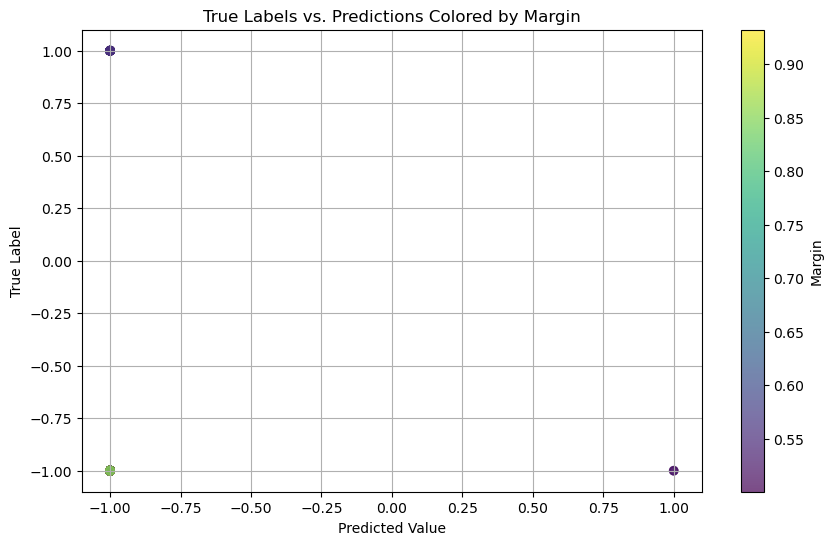

In [18]:
marginfied_df['True_Label'] = y_test.values

accuracy = accuracy_score(marginfied_df['True_Label'], marginfied_df['Classification'])
print("Accuracy (Decision Stump):", accuracy)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(marginfied_df['Classification'], marginfied_df['True_Label'], c=marginfied_df['Response'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Margin')
plt.xlabel('Predicted Value')
plt.ylabel('True Label')
plt.title('True Labels vs. Predictions Colored by Margin')
plt.grid(True)
plt.show()


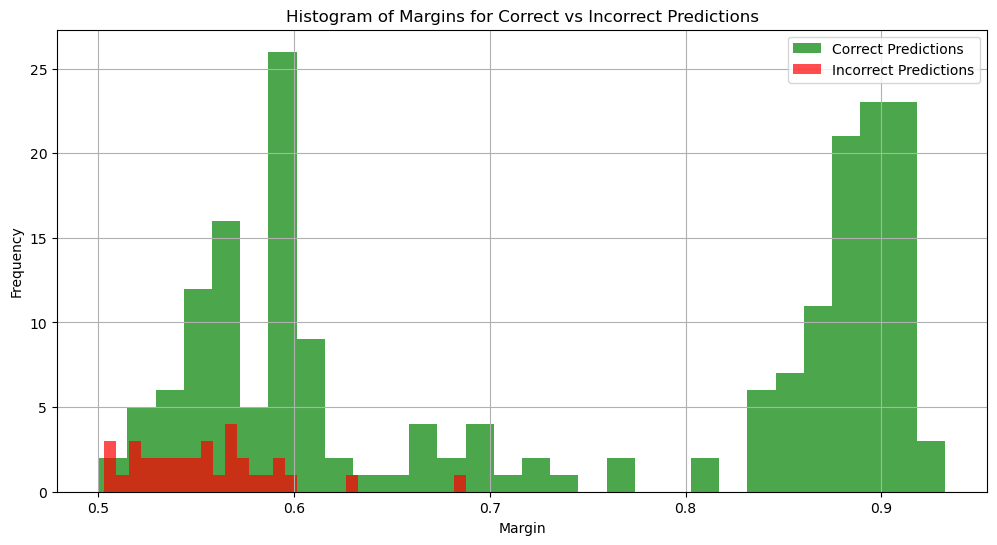

In [19]:
#plotting margins of correct and incorrect predictions

correct_margins = marginfied_df[marginfied_df['Classification'] == marginfied_df['True_Label']]['Response']
incorrect_margins = marginfied_df[marginfied_df['Classification'] != marginfied_df['True_Label']]['Response']
plt.figure(figsize=(12, 6))
plt.hist(correct_margins, bins=30, alpha=0.7, label='Correct Predictions', color='g')
plt.hist(incorrect_margins, bins=30, alpha=0.7, label='Incorrect Predictions', color='r')
plt.xlabel('Margin')
plt.ylabel('Frequency')
plt.title('Histogram of Margins for Correct vs Incorrect Predictions')
plt.legend()
plt.grid(True)
plt.show()


> It's quite reassuring that the highest margins that model has are related to correct predictions, whereas all the incorrect ones have the lower half of margin values. This demonstrates that the model is pretty confident about its predictions and very unlikely would hallucinate.

### 1.3 Adjust Weak Classifier Type: 


In [22]:
#modified adaboost function to accept a new variable -- classifier_of_choice

def adaboost_with_clfr_choice(features, target, classifier_of_choice, boosts=50):
    x = features.to_numpy()
    N = len(target)
    T = boosts
    dim = len(features.columns)
    alpha = np.zeros(T, dtype=np.float64)
    h = np.zeros([T, 3], dtype=np.float64)  
    weight = np.ones(N) / N
    err = np.ones(T, dtype=np.float64) * np.inf

    predictions_matrix = np.zeros((N, T))

    for t in range(T):
        min_error = np.inf
        best_feature = None
        best_classifier = None
        best_predictions = None
        
        for feature in range(dim):
            clf = classifier_of_choice
            clf.fit(x[:, [feature]], target)
            predictions = clf.predict(x[:, [feature]])

            weighted_error = np.sum(weight * (predictions != target)) / np.sum(weight)
            
            if weighted_error < min_error:
                min_error = weighted_error
                best_classifier = clf
                best_feature = feature
                best_predictions = predictions

        alpha[t] = calculate_alpha(min_error)
        
        h[t, 0] = best_feature  
        h[t, 1] = alpha[t]      
        h[t, 2] = min_error     

        predictions_matrix[:, t] = best_predictions

        classification = np.where(best_predictions == target, 1, -1)
        weight = update_weights(weight, alpha[t], classification, target)
        weight = normalise_weights(weight)

    classifier_df = pd.DataFrame(h, columns=['feature', 'alpha', 'error'])
    return classifier_df, predictions_matrix

def classify_sample_with_clfr_choice(xi, boost_classif, predictions_matrix, row_idx):
    classification_sum = np.float64(0)

    for t, (feat, alpha, _) in enumerate(boost_classif.values):
        feature_value = xi.iloc[int(feat)]
        prediction = predictions_matrix[row_idx, t]
        
        if prediction == 1:
            classification_sum += alpha
        else:
            classification_sum -= alpha

    final_class = np.sign(classification_sum)

    return final_class

In [23]:
#train NB
nb_classifier = GaussianNB()
classifier_df_NB, predictions_matrix_NB = adaboost_with_clfr_choice(X_train, y_train, nb_classifier, boosts=30)

#predict
classified_df_NB = X_test.reset_index(drop=True).apply(lambda xi: classify_sample_with_clfr_choice(xi, classifier_df_NB, predictions_matrix_NB, xi.name), axis=1)
classified_df_NB.name = 'Response'

#evaluate
accuracy = accuracy_score(y_test.reset_index(drop=True), classified_df_NB)
print("Accuracy (NB):", accuracy)

Accuracy (NB): 0.8614718614718615


In [24]:
#train kNN
knn_classifier = KNeighborsClassifier(n_neighbors=3)
classifier_df_kNN, predictions_matrix_kNN = adaboost_with_clfr_choice(X_train, y_train, knn_classifier, boosts=30)

#predict
classified_df_kNN = X_test.reset_index(drop=True).apply(lambda xi: classify_sample_with_clfr_choice(xi, classifier_df_kNN, predictions_matrix_kNN, xi.name), axis=1)
classified_df_kNN.name = 'Response'

#evaluate
accuracy = accuracy_score(y_test.reset_index(drop=True), classified_df_kNN)
print("Accuracy (kNN):", accuracy)

Accuracy (kNN): 0.8484848484848485


In [25]:
#train LR
lr_classifier = LogisticRegression()
classifier_df_LR, predictions_matrix_LR = adaboost_with_clfr_choice(X_train, y_train, lr_classifier, boosts=30)

#predict
classified_df_LR = X_test.reset_index(drop=True).apply(lambda xi: classify_sample_with_clfr_choice(xi, classifier_df_LR, predictions_matrix_LR, xi.name), axis=1)
classified_df_LR.name = 'Response'

#evaluate
accuracy = accuracy_score(y_test.reset_index(drop=True), classified_df_LR)
print("Accuracy (LR):", accuracy)

Accuracy (LR): 0.8614718614718615


### 1.4. Adjust Classification Threshold:




In [27]:
#making adaboost that will treat missclassification with more weight

def adaBoost_with_rate(X, y, classifier_of_choice, boosts, rate):
    n_samples, n_features = X.shape
    weights = np.ones(n_samples) / n_samples
    classifiers = []
    alpha_values = []

    for i in range(boosts):
        classifier = classifier_of_choice()
        classifier.fit(X, y, sample_weight=weights)
        predictions = classifier.predict(X)
        
        misclassified = (predictions != y)
        error = np.dot(weights, misclassified) / np.sum(weights)
        
        alpha = rate * np.log((1 - error) / (error + 1e-10))
        alpha_values.append(alpha)
        classifiers.append(classifier)
        
        weights *= np.exp(alpha * misclassified)
        weights /= np.sum(weights)  

    return classifiers, alpha_values


In [28]:
#adjusting threshold for precision-recall focus

def predict_with_threshold(X, classifiers, alphas, threshold):
    weighted_sum = np.zeros(X.shape[0])
    for alpha, classifier in zip(alphas, classifiers):
        weighted_sum += alpha * classifier.predict(X)
    
    predictions = np.where(weighted_sum >= threshold, 1, -1)
    return predictions


In [29]:
#rate 10 and threshold 5
classifiers10, alphas10 = adaBoost_with_rate(X_train, y_train, GaussianNB, boosts=50, rate = 10.0)
threshold5 = 5
y_pred10 = predict_with_threshold(X_test, classifiers10, alphas10, threshold5)
accuracy10 = accuracy_score(y_test, y_pred10)
precision10 = precision_score(y_test, y_pred10)
recall10 = recall_score(y_test, y_pred10)
f110 = f1_score(y_test, y_pred10)

print(f"Accuracy: {accuracy10}")
print(f"Precision: {precision10}")
print(f"Recall: {recall10}")
print(f"F1 Score: {f110}")


Accuracy: 0.3116883116883117
Precision: 0.16042780748663102
Recall: 0.9375
F1 Score: 0.273972602739726


In [30]:
#rate 2 and threshold 0.5
classifiers2, alphas2 = adaBoost_with_rate(X_train, y_train, GaussianNB, boosts=50, rate = 2.0)

threshold05 = 0.5
y_pred2 = predict_with_threshold(X_test, classifiers2, alphas2, threshold05)
# Evaluate performance
accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2)
recall2 = recall_score(y_test, y_pred2)
f12 = f1_score(y_test, y_pred2)

print(f"Accuracy: {accuracy2}")
print(f"Precision: {precision2}")
print(f"Recall: {recall2}")
print(f"F1 Score: {f12}")


Accuracy: 0.7056277056277056
Precision: 0.16666666666666666
Recall: 0.28125
F1 Score: 0.20930232558139536


> The higher rate and threshlods are, the higher recall, but precision and accuracy suffers. We can use it when capturing positive predictions is more important than mistaking them with negative ones. When we use an average rate and lower thresholds it looks more balanced: accuracy is good, but the recall is low. Overall, we observe the classical recall-precision trade-off, which allows us to tune the model depending on our goals and priorities.

### 1.5 Implement an ensemble pruning/optimisation

In [33]:
def generate_test_predictions_matrix(X_test, classifier_df, classifier_type):
    N = len(X_test)
    T = len(classifier_df)
    predictions_matrix_test = np.zeros((N, T))
    
    for i in range(T):
        feature_idx = int(classifier_df.iloc[i]['feature'])
        classifier = classifier_type()
        classifier.fit(X_train.iloc[:, [feature_idx]], y_train)
        predictions_matrix_test[:, i] = classifier.predict(X_test.iloc[:, [feature_idx]])
    
    return predictions_matrix_test

In [34]:
#function to prun classifiers with lowest weights

def prune_ensemble(classifier_df, predictions_matrix_test, pruning_fraction=0.2):
    num_to_prune = int(len(classifier_df) * pruning_fraction)
    pruned_classifier_df = classifier_df.sort_values(by='alpha', ascending=False).iloc[:-num_to_prune]
    pruned_predictions_matrix = predictions_matrix_test[:, pruned_classifier_df.index]
    return pruned_classifier_df, pruned_predictions_matrix

In [35]:
def predict_with_pruned_ensemble(features, pruned_classifier_df, pruned_predictions_matrix):
    N = len(features)
    final_predictions = np.zeros(N)
    
    for index, row in pruned_classifier_df.iterrows():
        feature = int(row['feature'])
        alpha = row['alpha']
        final_predictions += alpha * pruned_predictions_matrix[:, pruned_classifier_df.index.get_loc(index)]
    
    return np.sign(final_predictions)

In [36]:
#prune with NB
predictions_matrix_test_NB = generate_test_predictions_matrix(X_test, classifier_df_NB, GaussianNB)
pruned_classifier_df, pruned_predictions_matrix = prune_ensemble(classifier_df_NB, predictions_matrix_test_NB, pruning_fraction=0.9)
y_pruned_pred = predict_with_pruned_ensemble(X_test, pruned_classifier_df, pruned_predictions_matrix)
pruned_accuracy = accuracy_score(y_test, y_pruned_pred)
print(f"Pruned Accuracy: {pruned_accuracy}")
pruned_precision = precision_score(y_test, y_pruned_pred, zero_division=0)
pruned_recall = recall_score(y_test, y_pruned_pred, zero_division=0)
pruned_f1 = f1_score(y_test, y_pruned_pred, zero_division=0)
print(f"Pruned Precision: {pruned_precision}")
print(f"Pruned Recall: {pruned_recall}")
print(f"Pruned F1 Score: {pruned_f1}")
#Regular Accuracy (NB): 0.8614718614718615

Pruned Accuracy: 0.8614718614718615
Pruned Precision: 0.0
Pruned Recall: 0.0
Pruned F1 Score: 0.0


In [37]:
predictions_matrix_test_kNN = generate_test_predictions_matrix(X_test, classifier_df_kNN, KNeighborsClassifier)
pruned_classifier_dfknn, pruned_predictions_matrixknn = prune_ensemble(
    classifier_df_kNN, predictions_matrix_test_kNN, pruning_fraction=0.9)
y_pruned_predknn = predict_with_pruned_ensemble(
    X_test, pruned_classifier_dfknn, pruned_predictions_matrixknn)
pruned_accuracyknn = accuracy_score(y_test, y_pruned_predknn)
print(f"Pruned Accuracy: {pruned_accuracyknn}")
pruned_precisionknn = precision_score(y_test, y_pruned_predknn, zero_division=0)
pruned_recallknn = recall_score(y_test, y_pruned_predknn, zero_division=0)
pruned_f1knn = f1_score(y_test, y_pruned_predknn, zero_division=0)
print(f"Pruned Precision: {pruned_precisionknn}")
print(f"Pruned Recall: {pruned_recallknn}")
print(f"Pruned F1 Score: {pruned_f1knn}")
#Regular Accuracy (kNN): 0.8484848484848485

Pruned Accuracy: 0.8614718614718615
Pruned Precision: 0.0
Pruned Recall: 0.0
Pruned F1 Score: 0.0


> Apparently, pruning causes decrease in prediction diversity and goes down to predicting everything as -1 since it seems as the safest option that increases accuracy more


## 2. Applying obtained AdaBoost Algorithm

In [40]:
#train
classifier_df_kag = adaboost_with_decision_stump(X, y, boosts=50)

In [41]:
test_set = main_test.copy()
test_set['Gender'] = test_set['Gender'].map({False: -1, True: 1})
test_set['Driving_License'] = test_set['Driving_License'].map({False: -1, True: 1})
test_set['Previously_Insured'] = test_set['Previously_Insured'].map({False: -1, True: 1})
test_set['Vehicle_Damage'] = test_set['Vehicle_Damage'].map({False: -1, True: 1})

In [42]:
def classify_with_margins2(features_set_df, classifier_df):
    features_array = features_set_df.to_numpy()
    
    test_set_x_df = features_set_df.copy()
    test_set_x_df['sum_alpha'] = 0.0
    test_set_x_df['pos_votes'] = 0.0
    test_set_x_df['neg_votes'] = 0.0
    
    classified_df = sum_classifier_votes_for_each_sample(features_array, test_set_x_df, classifier_df)
    
    total_alpha_votes = np.sum(classifier_df.alpha)
    test_set_x_df['total_alpha_votes'] = total_alpha_votes
    
    sum_alpha = test_set_x_df['sum_alpha'].values
    pos_votes = test_set_x_df['pos_votes'].values
    neg_votes = test_set_x_df['neg_votes'].values
    total_alpha_votes = test_set_x_df['total_alpha_votes'].values
    
    test_set_x_df['Response'] = (sum_alpha / total_alpha_votes) * (pos_votes - neg_votes)
    
    return classified_df


In [43]:
#predict
classified_df_kag = classify_with_margins(test_set, classifier_df_kag)

In [44]:
classified_df_kag['Response'] = 1 - classified_df_kag['Response']
sub2 = pd.read_csv("datasets/sample_submission.csv")
sub2['Response'] = classified_df_kag['Response']
sub2.to_csv('datasets/my_submission_0.1.csv', index=False)
#sub2.describe()

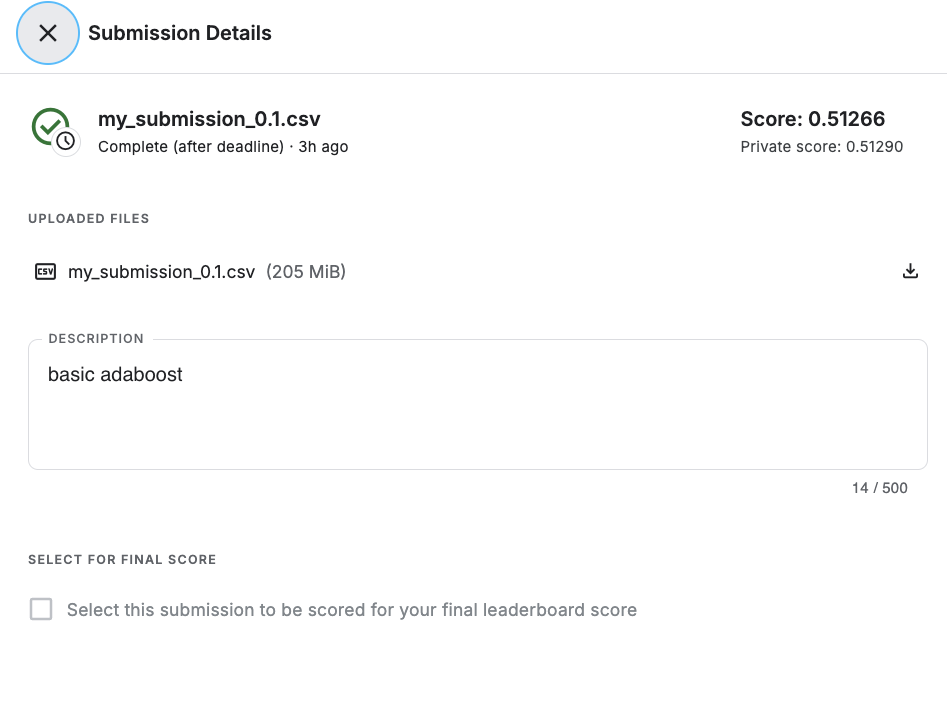

> Implemented AdaBoost Algoruthm gives a score of 0.51266, which is far from satisfactory, making it not much better than a classisfication by a coin flip. Although manuak impplementation of AdaBoost is definitely a skillful and eye-opening experience, it's more ensuring to use more advanced and accessible in-library Ensemble Algoritms.

## 3. Kaggle Competition Using a Range of Algorithms 

In [48]:
mainain = pd.read_csv('datasets/train.csv').drop('id', axis=1)
response = mainain['Response']
_, reduced_train = train_test_split(mainain, test_size=0.0001, stratify=response, random_state=42)
reduced_train.to_csv('datasets/reduced_train.csv', index=False)
main_train = pd.read_csv('datasets/reduced_train.csv')
main_test = pd.read_csv('datasets/test.csv').drop('id', axis=1)
extra_data = pd.read_csv('datasets/reduced_train.csv')
def prepare_data(df):
    
    df['Vehicle_Age'] = df['Vehicle_Age'].replace({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})
    df['Vehicle_Damage'] = df['Vehicle_Damage'].replace({'No':0, 'Yes':1})
    df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})
    
    df['Vehicle_Age'] = df['Vehicle_Age'].astype('int8')
    df[['Gender', 'Vehicle_Damage']] = df[['Gender', 'Vehicle_Damage']].astype('bool')
    df[['Driving_License','Previously_Insured']] = df[['Driving_License','Previously_Insured']].astype('bool')
    df[['Age', 'Region_Code', 'Policy_Sales_Channel', 'Vintage']] = df[['Age', 'Region_Code', 'Policy_Sales_Channel', 'Vintage']].astype('int16')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    
    if 'Response' in df.columns:
        df['Response'] = df['Response'].astype('bool')
    return df
main_train = prepare_data(main_train)
extra_data = prepare_data(extra_data)
main_test = prepare_data(main_test)
#main_train.info()
#extra_data.info()
#main_test.info()
X, y = main_train.drop('Response', axis=1), main_train['Response']

In [49]:
#XGB
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_stacking, xgb_stacking_test = np.zeros(len(X)), np.zeros(len(main_test))

for train_idx, val_idx in skf.split(X, y):
    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    eval_set = [(X_val, y_val)]
    
    X_tr = pd.concat([X_tr, extra_data.drop('Response', axis=1)], ignore_index=True)
    y_tr = pd.concat([y_tr, extra_data['Response']], ignore_index=True)
    
    xgb_params = {
    
    'n_estimators': 10000,
    'eta': 0.05,
    'alpha':  0.2545607592482198,
    'subsample': 0.8388163485383147, 
    'colsample_bytree': 0.2732499701466825, 
    'max_depth': 16,
    'min_child_weight': 5,
    'gamma': 0.0017688666476104672,
    'eval_metric': 'auc',
    'max_bin': 262143,
    'tree_method':"hist",
#    'device':"cuda",
}

    xgb_model = XGBClassifier(**xgb_params, early_stopping_rounds=50, random_state=42)
    xgb_model.fit(X_tr, y_tr, eval_set=eval_set, verbose=False)
    best_iteration = xgb_model.best_iteration
    
    stack_preds = xgb_model.predict_proba(X_val, iteration_range=(0, best_iteration))[:, 1]
    test_preds = xgb_model.predict_proba(main_test, iteration_range=(0, best_iteration))[:, 1]
    
    xgb_stacking[val_idx] = stack_preds
    xgb_stacking_test += test_preds / skf.get_n_splits()

In [50]:
#LGBM
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgbm_stacking, lgbm_stacking_test = np.zeros(len(X)), np.zeros(len(main_test))

for train_idx, val_idx in skf.split(X, y):
    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    eval_set = [(X_val, y_val)]
    
    X_tr = pd.concat([X_tr, extra_data.drop('Response', axis=1)], ignore_index=True)
    y_tr = pd.concat([y_tr, extra_data['Response']], ignore_index=True)
    
    lgbm_params = {'n_estimators': 2000,
                   "verbose": -1,
                   'depth': 6,
                   "eval_metric": "auc",
                   "max_bin": 262143,
                   'num_leaves': 223,
                   'learning_rate': 0.3, 
                   'min_child_samples': 54,
                   'subsample': 0.5395472919165504,
                   'colsample_bytree': 0.547518064129546,
                   'lambda_l1': 3.4444245446562,
                   'lambda_l2': 2.87490408088595e-05}

    lgbm_model = LGBMClassifier(**lgbm_params, random_state=42)
    lgbm_model.fit(X_tr, y_tr, eval_set=eval_set, eval_metric='auc', callbacks=[early_stopping(30)])
    best_iteration = lgbm_model.best_iteration_
    
    stack_preds = lgbm_model.predict_proba(X_val, num_iteration=best_iteration)[:, 1]
    test_preds = lgbm_model.predict_proba(main_test, num_iteration=best_iteration)[:, 1]
    
    lgbm_stacking[val_idx] = stack_preds
    lgbm_stacking_test += test_preds / skf.get_n_splits()

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.928645	valid_0's binary_logloss: 0.217738
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.925202	valid_0's binary_logloss: 0.223752
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.951025	valid_0's binary_logloss: 0.196138
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.923798	valid_0's binary_logloss: 0.218181
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.928925	valid_0's binary_logloss: 0.214665


In [51]:
#CatBoost
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cat_stacking, cat_stacking_test = np.zeros(len(X)), np.zeros(len(main_test))

for train_idx, val_idx in skf.split(X, y):
    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    eval_set = [(X_val, y_val)]
    
    X_tr = pd.concat([X_tr, extra_data.drop('Response', axis=1)], ignore_index=True)
    y_tr = pd.concat([y_tr, extra_data['Response']], ignore_index=True)
    
    cat_params = {
    'iterations': 10000,
    'eval_metric': 'AUC',
    'task_type': 'CPU',  
    'learning_rate': 0.05,
    'depth': 9,
    'l2_leaf_reg': 55.37964307854247,
    'max_bin': 404,
    'bagging_temperature': 0.017138393608280057,
    'random_strength': 9.256288011643901

}

    cat_model = CatBoostClassifier(**cat_params, random_state=42, logging_level='Silent',cat_features=main_test.columns.values)
    cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    stack_preds = cat_model.predict_proba(X_val)[:, 1]
    test_preds = cat_model.predict_proba(main_test)[:, 1]
    
    cat_stacking[val_idx] = stack_preds
    cat_stacking_test += test_preds / skf.get_n_splits()

In [52]:
stacking_df = pd.DataFrame({
    'xgb_proba': xgb_stacking,
    'lgbm_proba': lgbm_stacking,
    'cat_proba': cat_stacking
})

stacking_test_df = pd.DataFrame({
    'xgb_proba': xgb_stacking_test,
    'lgbm_proba': lgbm_stacking_test,
    'cat_proba': cat_stacking_test
})
meta_model_params = {
    'n_estimators': 43,
    'alpha': 0.000759453839369262,
    'subsample': 0.8635904939859487,
    'colsample_bytree': 0.7579443772400538,
    'max_depth': 7, 'min_child_weight': 5,
    'learning_rate': 0.13688008280542863,
    'gamma': 0.19965095682630274
}

meta_model = XGBClassifier(**meta_model_params, random_state=42)
meta_model.fit(stacking_df, y)

XGBClassifier(alpha=0.000759453839369262, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7579443772400538, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.19965095682630274, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.13688008280542863, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=43, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [53]:
test_preds = meta_model.predict_proba(stacking_test_df)[:,1]
sub = pd.read_csv("datasets/sample_submission.csv")
sub['Response'] = test_preds
#sub.to_csv('datasets/submission.csv', index=False)

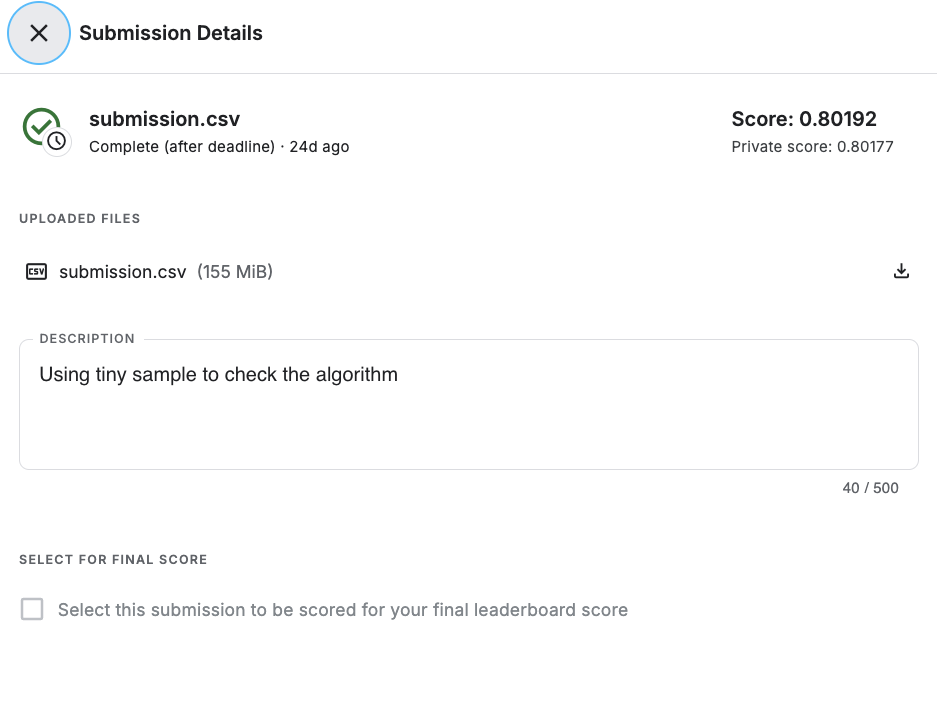

> By comparing three other Ensemble Algorithms -- XGB, CatBoost, and LBGM -- hte best performing one was chosen to submit to Competition. Thus, the more improved Score of 0.801 was obtained as a result of XGB model's perfomance.